In [24]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [25]:
from importlib import reload
reload(data_prepro)
reload(model_train)
reload(model_fcast)

<module 'model_fcast' from 'C:\\2023_11-PTSFC\\model_fcast.py'>

### Params

In [43]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically

# get current date and set time to 00:00
t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)
custom_date = '2024-01-03'
t_now = pd.Timestamp(custom_date).replace(hour=0, minute=0, second=0, microsecond=0)

# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday and wednesday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# - - - - - - - - - - - - - 
# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_thursday + pd.Timedelta(hours=fcast)).tz_localize('CET'))
print(subm_timestamps)

wed = 2024-01-03 00:00:00
thu = 2024-01-04 00:00:00
[Timestamp('2024-01-05 12:00:00+0100', tz='CET'), Timestamp('2024-01-05 16:00:00+0100', tz='CET'), Timestamp('2024-01-05 20:00:00+0100', tz='CET'), Timestamp('2024-01-06 12:00:00+0100', tz='CET'), Timestamp('2024-01-06 16:00:00+0100', tz='CET'), Timestamp('2024-01-06 20:00:00+0100', tz='CET')]


### Data Prep

In [46]:
# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()
df_energy.tail(5)

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # take smaller dataset
# start   = '2018-01-01'
# end     = df_energy['timestamp_CET'].max()
# df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
#                                 (df_energy['timestamp_CET'] <= end)]

# print('- '*15)
# print(f"take smaller dataset ... from {start} to {end}")
# print(df_energy_small.info())

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # feature engineering and preparing training data

# df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
# df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

# X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
# y_train_fturs = df_energy_fturs['gesamt']

# X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
# y_train_dummy = df_energy_dummy['gesamt']

> cwd = C:\2023_11-PTSFC
> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


> 0 NA in df
> last valid index = 2024-01-03 22:45:00+00:00
> done and saved to 2015-01-01_2024-01-03_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78960 entries, 2014-12-31 23:00:00+00:00 to 2024-01-03 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78960 non-null  datetime64[ns, CET]
 1   gesamt         78960 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-03 18:00:00+00:00,2024-01-03 19:00:00+01:00,60750.25
2024-01-03 19:00:00+00:00,2024-01-03 20:00:00+01:00,56969.25
2024-01-03 20:00:00+00:00,2024-01-03 21:00:00+01:00,54318.75
2024-01-03 21:00:00+00:00,2024-01-03 22:00:00+01:00,51718.50
2024-01-03 22:00:00+00:00,2024-01-03 23:00:00+01:00,48127.00


### Model Train

In [47]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train models 

# # quantile regression with dummies
# all_models_quant_reg = model_train.fit_quant_reg(X_train_dummy, y_train_dummy, quantiles=quantiles)

# # gradient boosting with features
# all_models_grad_boost = model_train.fit_grad_boost(X_train_fturs, y_train_fturs, quantiles=quantiles)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# save trained models

# fname_time = t_wednesday.strftime('%Y_%m_%d')
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# if not os.path.exists(path):
#     os.makedirs(path)

# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'wb') as handle:
#     pickle.dump(all_models_quant_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'wb') as handle:
#     pickle.dump(all_models_grad_boost, handle, protocol=pickle.HIGHEST_PROTOCOL)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# read trained models

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# get all files in directory that end with .pickle
all_files = [file for file in os.listdir(path) if file.endswith('.pickle')]

quant_reg_files = [file for file in all_files if 'quant_reg' in file]
grad_boost_files = [file for file in all_files if 'grad_boost' in file]

print(f"quant reg files: {quant_reg_files}")
print(f"grad boost files: {grad_boost_files}")

with open(f'{path}/{quant_reg_files[0]}', 'rb') as handle:
    all_models_quant_reg = pickle.load(handle)

with open(f'{path}/{grad_boost_files[0]}', 'rb') as handle:
    all_models_grad_boost = pickle.load(handle)

quant reg files: ['20150101_20240103_all_models_quant_reg.pickle']
grad boost files: ['20150101_20240103_all_models_grad_boost.pickle']


### Iterative Ensemble Forecast from Thursday

first input dataframe from 2023-12-27 22:00:00+00:00 to 2024-01-03 22:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-07 11:00:00+00:00 to 2024-01-07 22:00:00+00:00
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


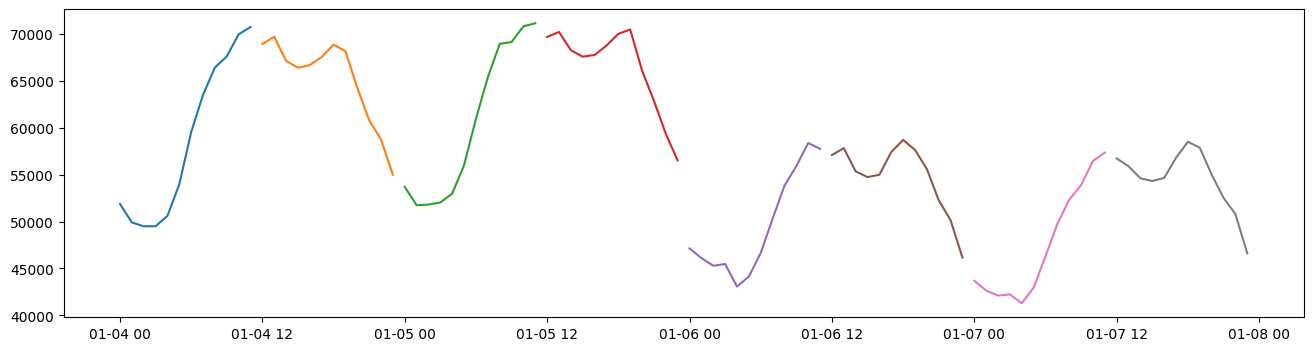

,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-03 23:00:00+00:00,44891.942285,51002.585218,51875.853231,54168.027723,57455.882983
2024-01-04 00:00:00+00:00,42732.805714,47932.130782,49895.845122,52058.836128,55013.436766
2024-01-04 01:00:00+00:00,42222.313761,46906.774654,49492.349512,51915.008568,54328.704174
2024-01-04 02:00:00+00:00,42437.014067,47294.354864,49492.196732,51972.539383,54264.755518
2024-01-04 03:00:00+00:00,44233.759205,49231.437303,50593.222198,52414.952192,54407.680869
...,...,...,...,...,...
2024-01-07 18:00:00+00:00,50444.002514,55862.725911,57861.048879,59047.555275,62356.145990
2024-01-07 19:00:00+00:00,47945.026794,52677.355755,55002.261355,56739.441885,59493.091104
2024-01-07 20:00:00+00:00,45066.837634,49835.358456,52524.206906,54275.310941,56307.888948
2024-01-07 21:00:00+00:00,43371.204077,48070.856409,50801.867545,52340.945245,55824.532347


In [48]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset to create future features for fcast
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(f"first input dataframe from {start} to {end}")

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

df_fcast_iter_all = pd.DataFrame()
iterations = 8
# fig, axes = plt.subplots(1, iterations, figsize=(iterations*8,4))
# axes = axes.flatten()
fig, ax = plt.subplots(1, 1, figsize=(16,4))

print('- '*15) 
print(f"> to be forecasted")
for fcast_iter in range(iterations):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        # print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=13, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

    print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}", end='\r')

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24]).tail(12)
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').tail(12)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (df_quant_reg_fcast['q 0.500'].values + df_grad_boost_fcast['q 0.500'].values) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop['timestamp_CET'] = df_ens_fcast_loop.index.tz_convert('CET')
    df_ens_fcast_loop['gesamt'] = ens_fcast
    df_ens_fcast_loop

    # plt.figure(figsize=(8,2))
    # ax = axes[fcast_iter]
    ax.plot(df_ens_fcast_loop['timestamp_CET'], ens_fcast)

    # save fcast to df
    df_ens_fcast_out = (df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5)
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_iter_all = pd.concat((df_fcast_iter_all, df_ens_fcast_out))

print('')
print('= '*15)
print(f"all iterative fcasts done ...")

plt.show()
display(df_fcast_iter_all)

#### Fix QC & Save to csv

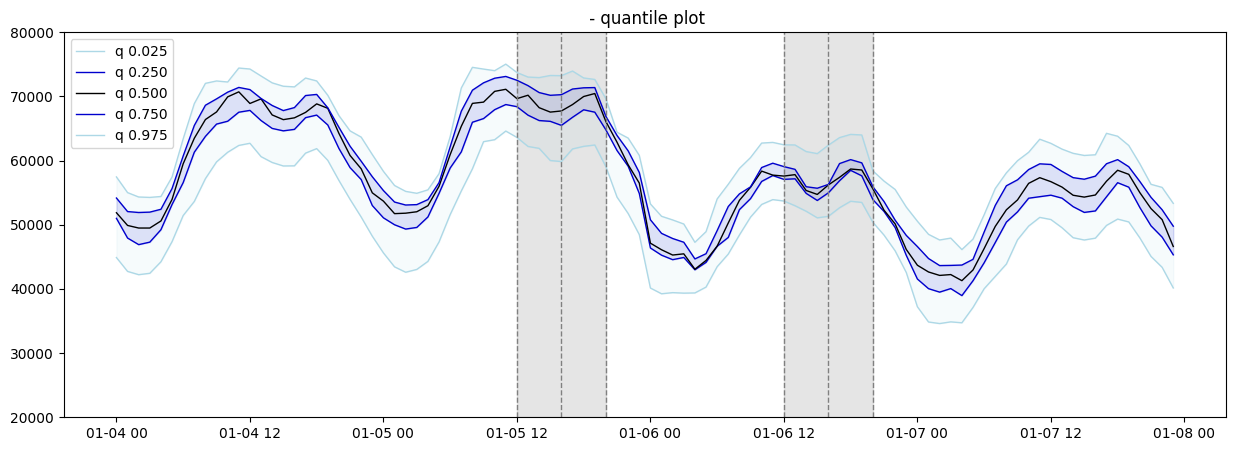

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-03,energy,36 hour,64.603698,68.738141,71.116032,73.117551,75.035538
1,2024-01-03,energy,40 hour,60.011560,66.120070,67.560355,70.178882,73.267289
2,2024-01-03,energy,44 hour,62.431783,67.548345,70.455279,71.383528,72.649778
3,2024-01-03,energy,60 hour,53.919582,57.670664,57.740170,59.596876,62.837272
4,2024-01-03,energy,64 hour,51.081869,53.791031,54.729454,55.695257,61.091071
5,2024-01-03,energy,68 hour,53.482846,57.628138,58.537187,59.651545,63.996559


In [49]:
# - - - - - - - - - - - - - 
# fix quantile crossing
df_iter_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_iter_all)
# current fcast index is based on UTC only, add CET col
df_iter_fcast_all_fixed['timestamp_CET'] = df_iter_fcast_all_fixed.index.tz_convert('CET')
# reorder cols
df_iter_fcast_all_fixed = df_iter_fcast_all_fixed[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_iter_fcast_all_fixed, subm_timestamps)

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_iter_fcast_all_fixed['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_iter_fcast_all_fixed.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

# - - - - - - - - - - - - - 
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)

# # save entire iterative fcast to csv
# df_iter_fcast_all_fixed.to_csv(f"{path}/{fname_time}_power_iterative_fcast.csv", index=False)

# # save submission fcast to csv
# df_sub.to_csv(f"{path}/{fname_time}_power_fcast_submission.csv", index=False)
# display(df_sub)

### Direct h-step Quant Reg Fcast

In [50]:
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

print('- '*15) 
print(f"> to be forecasted")
print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

# create df with fcast timestamps 
df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
df_temp['timestamp_CET'] = fcast_timestamp_CET
df_fcast_dummy = data_prepro.create_dummy_df(df_temp, hour_method='seasonal', holiday_method='separate')
# display(df_fcast_dummy)
# display(df_fcast_dummy.tail())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# fcast

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_direct_fcast = pd.DataFrame(index=df_fcast_dummy.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    pred = quant_reg_model.predict(df_fcast_dummy.drop('timestamp_CET', axis=1))
    df_quant_reg_direct_fcast[name] = pred

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-03 23:00:00+00:00 to 2024-01-07 22:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


#### Fix QC and Save

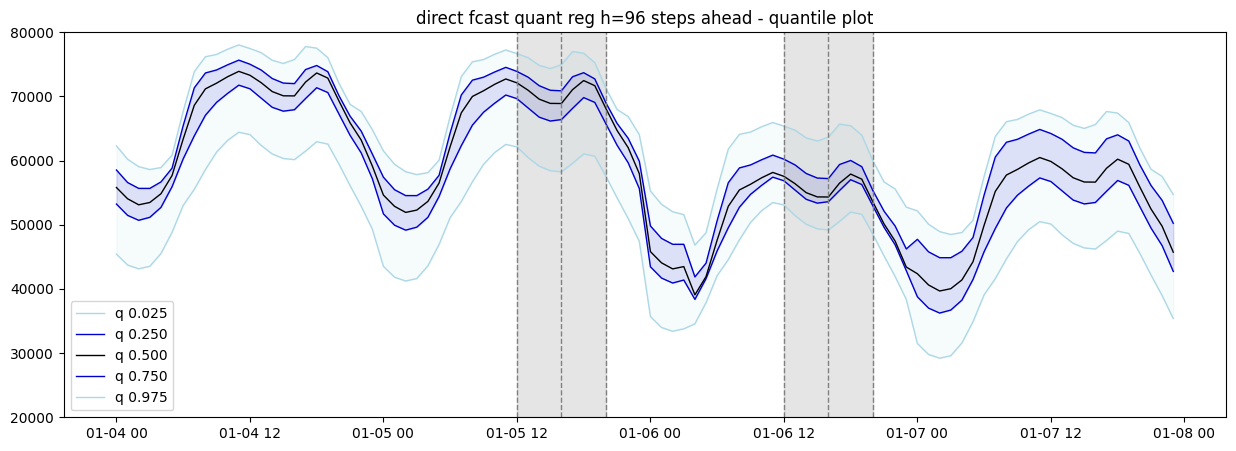

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-03,energy,36 hour,62.517250,70.221762,72.725875,74.536375,77.239167
1,2024-01-03,energy,40 hour,58.425583,66.169988,68.914875,70.962937,74.352083
2,2024-01-03,energy,44 hour,60.675167,69.070725,71.678125,72.734750,75.263694
3,2024-01-03,energy,60 hour,53.462083,57.424300,58.156750,60.858500,65.941222
4,2024-01-03,energy,64 hour,49.370417,53.372525,54.345750,57.285063,63.054139
5,2024-01-03,energy,68 hour,51.620000,56.273262,57.109000,59.056875,63.965750


In [51]:
# - - - - - - - - - - - - - 
# add CET col
df_quant_reg_direct_fcast['timestamp_CET'] = df_quant_reg_direct_fcast.index.tz_convert('CET')
# reorder cols
df_quant_reg_direct_fcast = df_quant_reg_direct_fcast[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_quant_reg_direct_fcast, subm_timestamps, title='direct fcast quant reg h=96 steps ahead')

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_quant_reg_direct_fcast['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_quant_reg_direct_fcast.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

display(df_sub)

### Naive Benchmark

In [52]:
print(df_energy.info())
df_energy.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78960 entries, 2014-12-31 23:00:00+00:00 to 2024-01-03 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78960 non-null  datetime64[ns, CET]
 1   gesamt         78960 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-03 18:00:00+00:00,2024-01-03 19:00:00+01:00,60750.25
2024-01-03 19:00:00+00:00,2024-01-03 20:00:00+01:00,56969.25
2024-01-03 20:00:00+00:00,2024-01-03 21:00:00+01:00,54318.75
2024-01-03 21:00:00+00:00,2024-01-03 22:00:00+01:00,51718.50
2024-01-03 22:00:00+00:00,2024-01-03 23:00:00+01:00,48127.00


In [53]:
# - - - - - - - - - - - - - 
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

fcast_timestamps = fcast_timestamp_CET
# fcast_timestamps = subm_timestamps

# - - - - - - - - - - - - - 
df_energy_benchmark = df_energy.copy()
df_energy_benchmark["month"] = df_energy_benchmark['timestamp_CET'].dt.month
df_energy_benchmark["weekday"] = df_energy_benchmark['timestamp_CET'].dt.weekday # Monday=0, Sunday=6
df_energy_benchmark["weeknum"] = df_energy_benchmark['timestamp_CET'].dt.isocalendar().week

last_t = 100
methods = ['linear', 'median_unbiased', 'normal_unbiased', 'weibull']

number_of_matches_in_past = 0
pred_baseline = np.zeros((len(methods),len(fcast_timestamps),5))

for i,d in enumerate(fcast_timestamps):
        
    weekday = d.weekday()
    hour = d.hour
    weeknum = d.week
    
    # condition that the weekday and hour match AND the weeknum is within +/- 2 weeks of the target
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['weeknum'].between(weeknum-2, weeknum+2)) 
    
    # alternatively:
    # condition that the weekday and hour match AND the month also matches
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark.index.month == d.month)

    # alternatively:
    # condition that the weekday and hour match AND the month is within +/- 1 months of the target
    cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['month'].between(d.month-1, d.month+1))

    match_df = df_energy_benchmark[cond]
    number_of_matches_in_past += match_df.shape[0] 

    for m_idx, method in enumerate(methods):
        pred_baseline[m_idx, i,:] = np.quantile(match_df.iloc[-last_t:]["gesamt"], q=quantiles, method=method)

number_of_matches_in_past = number_of_matches_in_past / len(fcast_timestamps)
print(f"avg number_of_matches_in_past = {number_of_matches_in_past:.2f}")

dict_benchmark_fcast = {}

for m_idx, method in enumerate(methods):

    print('- '*15)
    print(f"method = {method}")
    print('- '*15)
    
    df_benchmark = pd.DataFrame(index=fcast_timestamps, columns=[f"q {q:.3f}" for q in quantiles])
    df_benchmark.loc[:,:] = pred_baseline[m_idx,:,:]
    # - - - - - - - - - - - - - 
    # make sure all cols are float
    df_benchmark = df_benchmark.astype(float)
    # - - - - - - - - - - - - - 
    # add CET col
    df_benchmark['timestamp_CET'] = df_benchmark.index.tz_convert('CET')
    # reorder cols
    df_benchmark = df_benchmark[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]
    # - - - - - - - - - - - - - 
    # display(df_benchmark)

    dict_benchmark_fcast[method] = df_benchmark

avg number_of_matches_in_past = 76.25
- - - - - - - - - - - - - - - 
method = linear
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = median_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = normal_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = weibull
- - - - - - - - - - - - - - - 


#### Plot Naive Benchmark

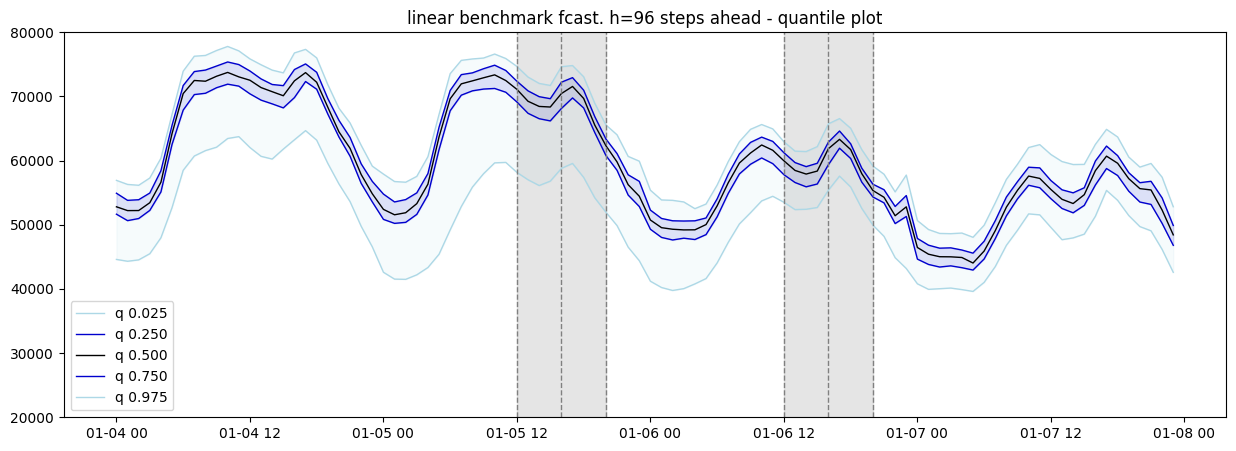

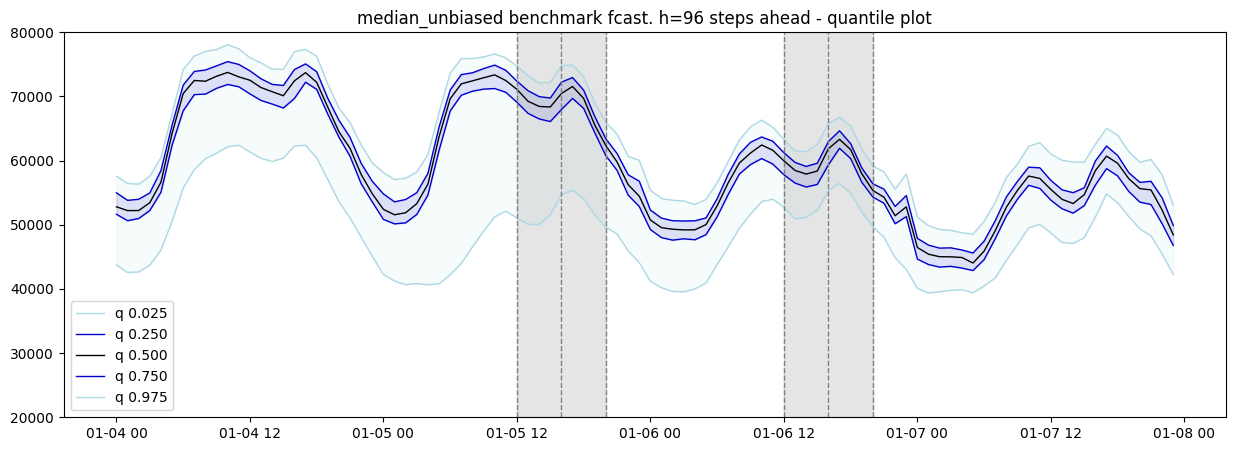

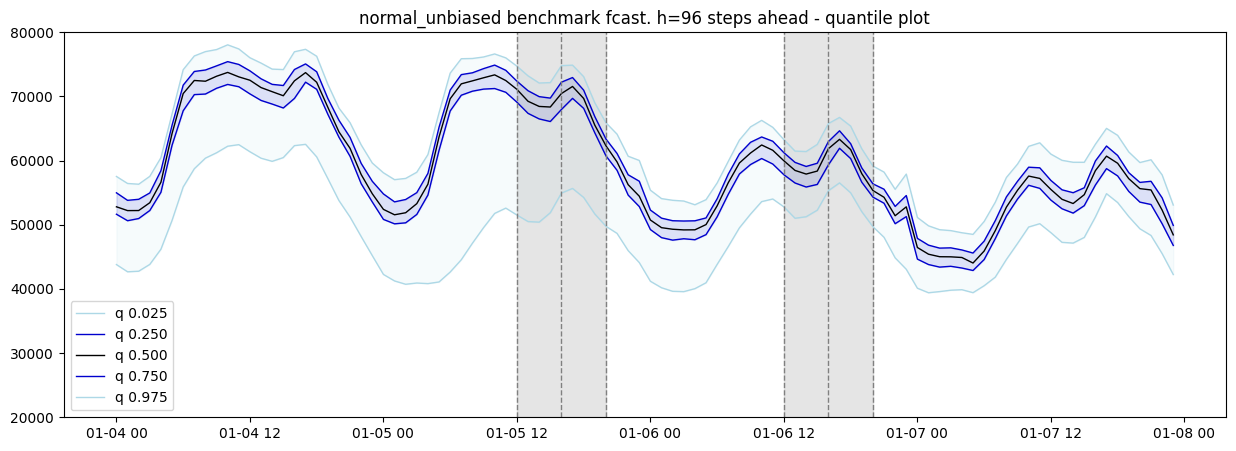

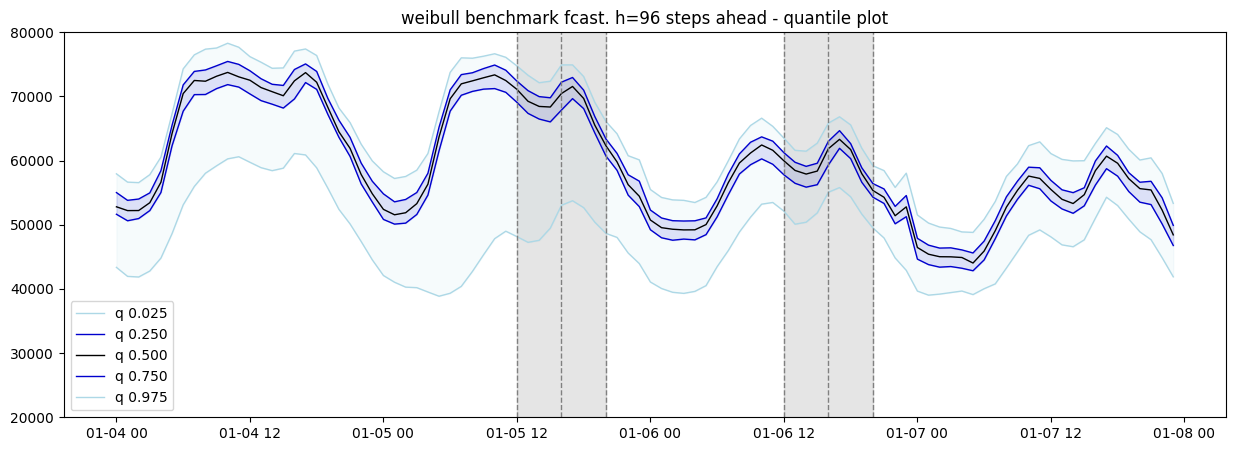

In [71]:
for method in methods:
    model_train.plot_quantile_fcast(dict_benchmark_fcast[method], subm_timestamps, title=f'{method} benchmark fcast. h=96 steps ahead')

In [66]:
# # compare the q 0.975 quantile of all benchmarks
# plt.figure(figsize=(15,5))
# for method in methods:
#     plt.plot(dict_benchmark_fcast[method]['timestamp_CET'], dict_benchmark_fcast[method]['q 0.975'], label=method)
# plt.legend()
# plt.show()

### Direct h-step Grad Boost Fcast using Naive Benchmark

### Combine Ensemble = Direct QR + Direct GB + Benchmark

### Get Actual Data

In [55]:
from importlib import reload
reload(data_prepro)
reload(model_train)

<module 'model_train' from 'C:\\2023_11-PTSFC\\model_train.py'>

In [56]:
""" 
now since we ran the model in retrospect on a past week 
we can compare the fcast with the actual values and compute quantile scores etc

"""

# = = = = = = = = = = = = = 
# import actual data

# # get days left till sunday
# days_left = 6 - t_now.dayofweek
# # get next saturday of week in t_now
# t_sunday = t_now + pd.Timedelta(days=days_left)
# print(f"sun = {t_sunday}")

# just get next thursday
t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next thu = {t_wednesday_next}")

# = = = = = = = = = = = = = 
# get data
df_energy_new = data_prepro.get_energy_data_today(to_date=t_wednesday_next.strftime('%Y%m%d'))
df_energy_new.info()
df_energy_new.tail(5)

next thu = 2024-01-10 00:00:00
> cwd = C:\2023_11-PTSFC
> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


> 0 NA in df
> last valid index = 2024-01-10 22:45:00+00:00
> done and saved to 2015-01-01_2024-01-10_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79128 entries, 2014-12-31 23:00:00+00:00 to 2024-01-10 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79128 non-null  datetime64[ns, CET]
 1   gesamt         79128 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-10 18:00:00+00:00,2024-01-10 19:00:00+01:00,68668.25
2024-01-10 19:00:00+00:00,2024-01-10 20:00:00+01:00,65446.75
2024-01-10 20:00:00+00:00,2024-01-10 21:00:00+01:00,62176.50
2024-01-10 21:00:00+00:00,2024-01-10 22:00:00+01:00,59633.00
2024-01-10 22:00:00+00:00,2024-01-10 23:00:00+01:00,56738.25


### Evaluation

In [63]:
reload(model_train)

<module 'model_train' from 'C:\\2023_11-PTSFC\\model_train.py'>

In [64]:
def eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[20_000, 80_000]):

    """ 
    imported data up to (and including) sunday of the fcast week
    first subset the required data from df_energy_new ...ie t_wednesday to t_sunday
    then plot the iterative fcast from thursday to sunday
    against the actual values in the same plot for comparison

    """
    # plot all actual values inbetween fcast timeframe
    mask = (df_energy_new['timestamp_CET'] >= df_fcast['timestamp_CET'].min()) & (df_energy_new['timestamp_CET'] <= df_fcast['timestamp_CET'].max())
    actual_df = df_energy_new.loc[mask]

    # plot actual values only for the fcast timestamps
    # actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # = = = = = = = = = = = = = 
    # plot

    plt.figure(figsize=(15, 5))
    plt.title(f'quantile fcast evaluation')

    cols = ['temp', 'lightblue', 'mediumblue', 'black', 'mediumblue', 'lightblue']
    for idx, quantile in enumerate(df_fcast.columns):
        if 'timestamp' in quantile:
            continue
        y_pred = df_fcast[quantile]
        # Plot the prediction line
        plt.plot(df_fcast['timestamp_CET'], y_pred, label=f'{quantile}', lw=1, alpha=1, color=cols[idx])

    plt.fill_between(df_fcast['timestamp_CET'], df_fcast['q 0.025'], df_fcast['q 0.975'], color='lightblue', alpha=0.1)
    plt.fill_between(df_fcast['timestamp_CET'], df_fcast['q 0.250'], df_fcast['q 0.750'], color='mediumblue', alpha=0.1)

    # highlight submission timeframes
    plt.axvspan(subm_timestamps[0], subm_timestamps[2], alpha=0.2, color='grey')
    plt.axvspan(subm_timestamps[3], subm_timestamps[5], alpha=0.2, color='grey')

    # for timestamp in submission idx, make vertical line
    for timestamp in subm_timestamps:
        plt.axvline(timestamp, color='grey', linestyle='--', lw=1)

    # plot actual values
    plt.plot(actual_df['timestamp_CET'], actual_df['gesamt'], lw=1, label='actual', color='red')

    plt.ylim(ylims)
    plt.legend()
    plt.show()

    """ 
    to calculate the error, we can only subset the actual values for the fcast timestamps
    because otherwise the actual_df will have more values than the fcast_df
    
    now that everything lines up ... we can compute the quantile scores 
    and other error metrics such as MAE, MAPE, MSE, etc
    do it for the entire iterative fcast and also for the 6 submission fcast timestamps

    """

    actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # for entire iterative fcast
    # ==========================
    print('- '*15)
    print(f"entire iterative fcast")
    print('- '*15)

    mae = mean_absolute_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MAE = {mae}")
    mse = mean_squared_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MSE = {mse}")
    mape = mean_absolute_percentage_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MAPE = {mape}")

    quantile_scores = []
    for q in quantiles:
        quantile_scores.append(mean_pinball_loss(actual_df['gesamt'], df_fcast[f'q {q:.3f}']))
    print(quantile_scores)

    # for submission fcast timestamps
    # ===============================
    print('- '*15)
    print(f"submission fcast timestamps")
    print('- '*15)

    mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'].isin(subm_timestamps), 'gesamt'].values, 
                              df_fcast.loc[df_fcast['timestamp_CET'].isin(subm_timestamps), 'q 0.500'].values)
    print(f"MAE q 0.5 = {mae}")

    df_error_metrics = pd.DataFrame(index=subm_timestamps)
    for timestamp in subm_timestamps:
        mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, 'q 0.500'].values)
        df_error_metrics.loc[timestamp, 'abs error q 0.5'] = mae

        for q in quantiles:
            quantile_score = mean_pinball_loss(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                               df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, f'q {q:.3f}'].values,
                                               alpha=q) / 1000 * 2
            # save in df
            df_error_metrics.loc[timestamp, f'q-score {q:.3f}'] = quantile_score

    # add last row to df_error_metrics which is the avg of the cols
    df_error_metrics.loc['avg', :] = df_error_metrics.mean(axis=0)
    
    display(df_error_metrics)

#### Evaluate only Submission File

,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
timestamp_UTC,,,,,,
2024-01-05 11:00:00+00:00,2024-01-05 12:00:00+01:00,55809.309375,64947.81250,67815.093750,70967.71875,74956.950000
2024-01-05 15:00:00+00:00,2024-01-05 16:00:00+01:00,54823.453125,62217.87500,64936.468750,69072.90625,73778.500000
2024-01-05 19:00:00+00:00,2024-01-05 20:00:00+01:00,51397.409375,57342.21875,60231.343750,64252.90625,67838.003125
2024-01-06 11:00:00+00:00,2024-01-06 12:00:00+01:00,49563.590625,53678.12500,55430.796875,58753.56250,62924.834375
2024-01-06 15:00:00+00:00,2024-01-06 16:00:00+01:00,47954.984375,51767.09375,53808.234375,57955.56250,62678.159375
2024-01-06 19:00:00+00:00,2024-01-06 20:00:00+01:00,45036.400000,48556.06250,50737.296875,54253.06250,57682.793750


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-05 11:00:00+00:00,2024-01-05 12:00:00+01:00,64140.00
2024-01-05 15:00:00+00:00,2024-01-05 16:00:00+01:00,61218.25
2024-01-05 19:00:00+00:00,2024-01-05 20:00:00+01:00,57408.50
2024-01-06 11:00:00+00:00,2024-01-06 12:00:00+01:00,56470.75
2024-01-06 15:00:00+00:00,2024-01-06 16:00:00+01:00,55334.50
2024-01-06 19:00:00+00:00,2024-01-06 20:00:00+01:00,53104.50


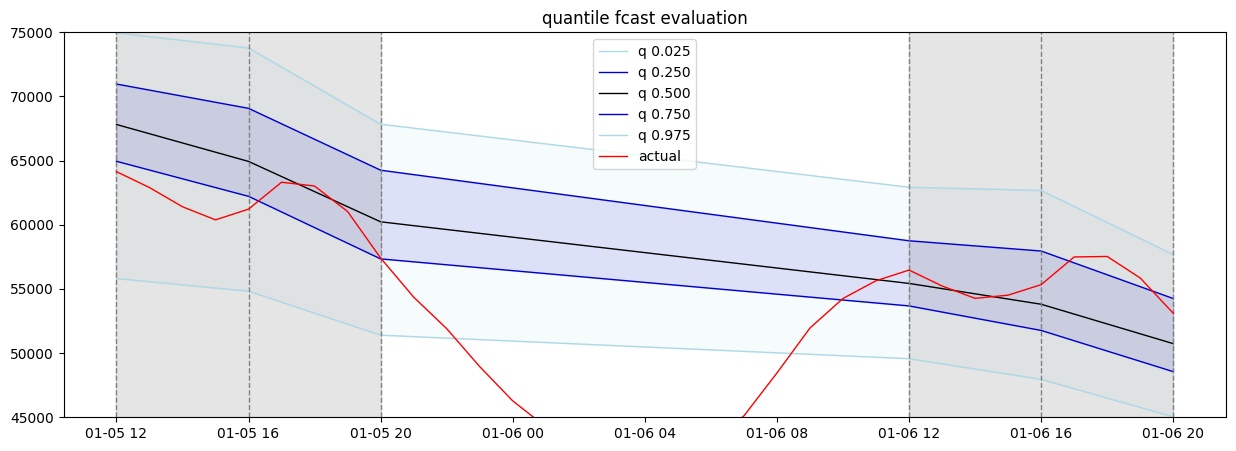

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2524.9296874999964
MSE = 7385758.579386368
MAPE = 0.04296348546321253
[3590.9460937499994, 1065.1822916666667, 1262.4648437499982, 2298.2682291666647, 4348.561718750004]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 2524.9296874999964


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,3675.093750,0.416535,1.211719,3.675094,3.413859,0.540848
2024-01-05 16:00:00+01:00,3718.218750,0.319740,1.499437,3.718219,3.927328,0.628013
2024-01-05 20:00:00+01:00,2822.843750,0.300555,0.033141,2.822844,3.422203,0.521475
2024-01-06 12:00:00+01:00,1039.953125,0.345358,1.396313,1.039953,1.141406,0.322704
2024-01-06 16:00:00+01:00,1526.265625,0.368976,1.783703,1.526266,1.310531,0.367183
2024-01-06 20:00:00+01:00,2367.203125,0.403405,2.274219,2.367203,0.574281,0.228915
avg,2524.929687,0.359095,1.366422,2.524930,2.298268,0.434856


In [58]:
# read in csv file

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"

# get csv filename from path that includes Thormund
fnames = [f for f in os.listdir(path) if 'Tormund' in f]
if len(fnames) > 0:
    fname = fnames[0]
else:
    print("no file found")

df_fcast = pd.read_csv(f"{path}/{fname}")
df_fcast = df_fcast[df_fcast.target == 'energy']
df_fcast['timestamp_CET'] = subm_timestamps
# make index = timestamp_CET turned to UTC
df_fcast.index = pd.to_datetime(df_fcast['timestamp_CET']).dt.tz_convert('UTC').rename('timestamp_UTC')
df_fcast = df_fcast[['timestamp_CET', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']]
df_fcast.columns = ['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']
df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] = df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] * 1000

display(df_fcast)
display(df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])])

eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[45_000, 75_000])

#### Evaluate Entire Fcast

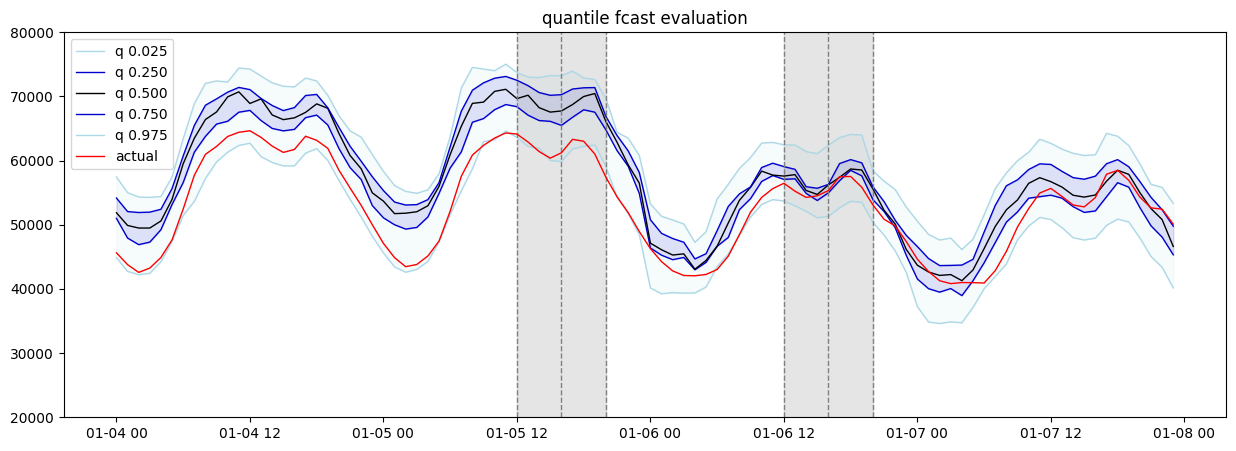

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 4322.728645255105
MSE = 25985352.31484117
MAPE = 0.08190701255142642
[1371.822191026399, 1586.3537416851243, 2161.3643226275526, 2973.0023837290196, 4476.874471813319]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 4199.208284243789


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,5519.493563,0.026207,6.399602,5.519494,4.189434,0.479440
2024-01-05 16:00:00+01:00,6520.349617,0.068342,6.409893,6.520350,4.528904,0.601062
2024-01-05 20:00:00+01:00,8670.326820,3.192618,11.064045,8.670327,4.737920,0.611634
2024-01-06 12:00:00+01:00,1118.508184,0.138356,0.909266,1.118508,1.297960,0.299725
2024-01-06 16:00:00+01:00,875.708098,0.200784,0.176213,0.875708,0.479264,0.353466
2024-01-06 20:00:00+01:00,2490.863424,0.136326,1.217777,2.490863,1.408144,0.264690
avg,4199.208284,0.627105,4.362799,4.199208,2.773604,0.435003


In [62]:
eval_fcast(df_iter_fcast_all_fixed, df_energy_new, subm_timestamps, quantiles)

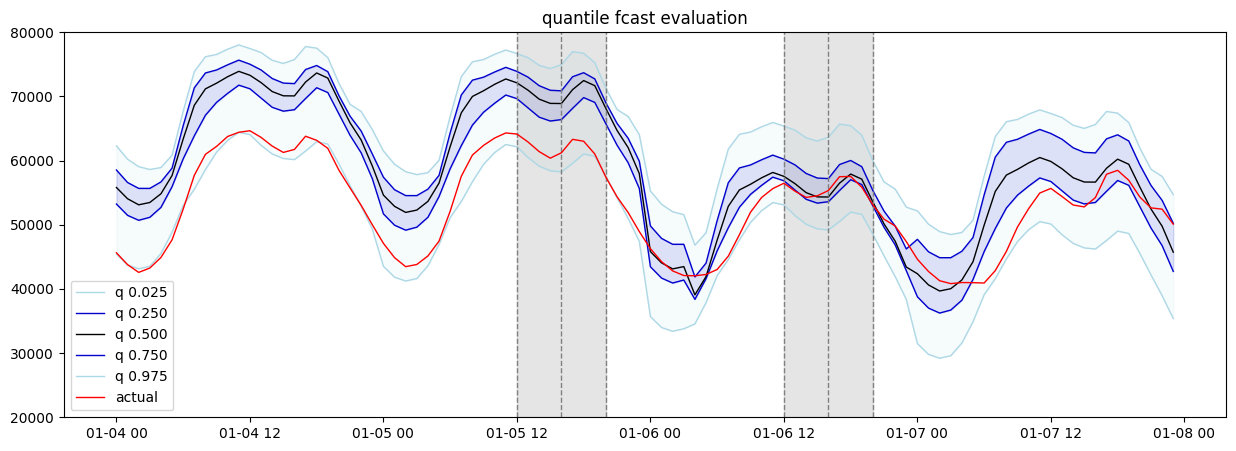

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6200.341145833333
MSE = 53168234.73763021
MAPE = 0.11693076879102353
[1989.3741319444443, 2317.5235677083333, 3100.1705729166665, 4228.143229166667, 6041.533854166667]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 4816.229166666667


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,7977.125000,0.099608,8.275537,7.977125,4.881500,0.626810
2024-01-05 16:00:00+01:00,7679.875000,0.148429,7.766325,7.679875,4.830031,0.687126
2024-01-05 20:00:00+01:00,10711.375000,0.297375,12.479362,10.711375,5.797438,0.693143
2024-01-06 12:00:00+01:00,1077.250000,0.168904,0.583219,1.077250,1.877188,0.445375
2024-01-06 16:00:00+01:00,1005.500000,0.307000,0.868081,1.005500,0.932969,0.416417
2024-01-06 20:00:00+01:00,446.250000,0.229933,0.086944,0.446250,1.110500,0.343446
avg,4816.229167,0.208542,5.009911,4.816229,3.238271,0.535386


In [60]:
eval_fcast(df_quant_reg_direct_fcast, df_energy_new, subm_timestamps, quantiles)

#### Evaluation of Benchmark

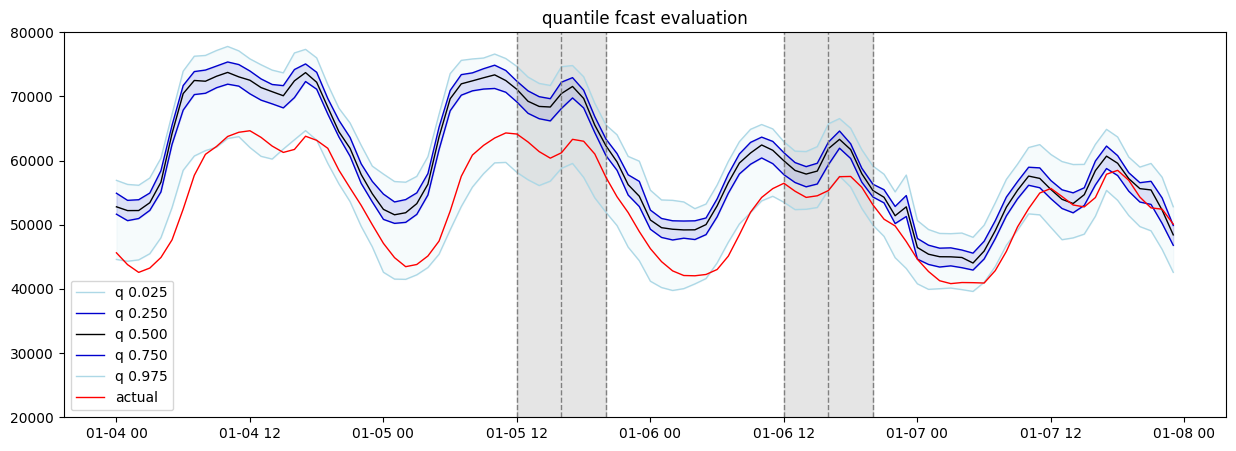

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6688.33984375
MSE = 60096901.95296224
MAPE = 0.12808195265973898
[1448.1023111979166, 2633.9521484375, 3344.169921875, 4049.1819661458335, 5288.098763020832]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 5561.9375


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,6962.1250,0.298903,7.492500,6.962125,4.112000,0.526864
2024-01-05 16:00:00+01:00,9232.1250,0.121525,10.365000,9.232125,5.500031,0.670788
2024-01-05 20:00:00+01:00,4915.6250,0.272777,5.069625,4.915625,2.979812,0.407498
2024-01-06 12:00:00+01:00,3498.7500,0.148179,2.004750,3.498750,2.380625,0.323332
2024-01-06 16:00:00+01:00,6524.7500,0.112466,6.039000,6.524750,3.772750,0.519643
2024-01-06 20:00:00+01:00,2238.2500,0.157696,1.848750,2.238250,1.609750,0.302564
avg,5561.9375,0.185258,5.469938,5.561937,3.392495,0.458448


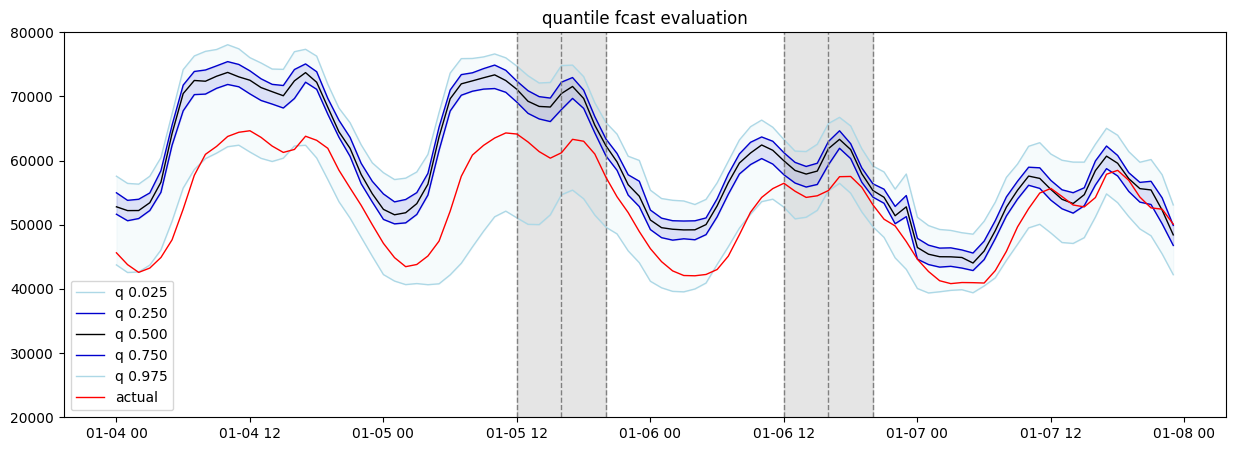

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6688.33984375
MSE = 60096901.95296224
MAPE = 0.12808195265973898
[2156.9094292534724, 2616.459526909722, 3344.169921875, 4059.8364800347226, 5419.785091145834]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 5561.9375


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,6962.1250,0.653269,7.439000,6.962125,4.119000,0.528835
2024-01-05 16:00:00+01:00,9232.1250,0.327232,10.110000,9.232125,5.500906,0.679718
2024-01-05 20:00:00+01:00,4915.6250,0.389191,4.998125,4.915625,2.983229,0.426111
2024-01-06 12:00:00+01:00,3498.7500,0.186440,1.986500,3.498750,2.382625,0.340876
2024-01-06 16:00:00+01:00,6524.7500,0.001573,6.009250,6.524750,3.819583,0.522128
2024-01-06 20:00:00+01:00,2238.2500,0.170735,1.815875,2.238250,1.641917,0.302809
avg,5561.9375,0.288073,5.393125,5.561937,3.407877,0.466746


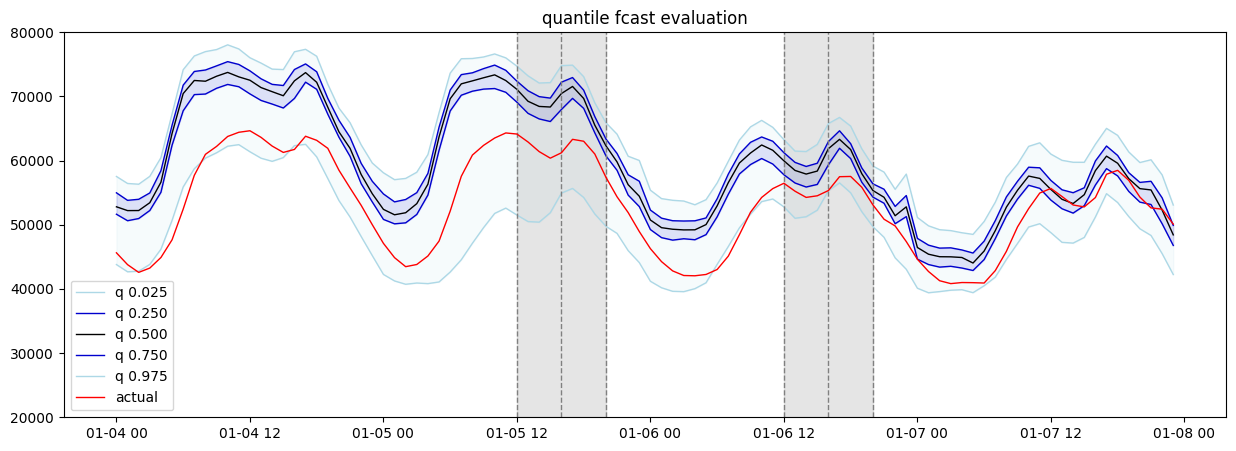

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6688.33984375
MSE = 60096901.95296224
MAPE = 0.12808195265973898
[2109.7879964192707, 2617.5528157552085, 3344.169921875, 4059.1705729166665, 5411.554695638021]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 5561.9375


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,6962.1250,0.631121,7.442344,6.962125,4.118563,0.528712
2024-01-05 16:00:00+01:00,9232.1250,0.314375,10.125937,9.232125,5.500852,0.679159
2024-01-05 20:00:00+01:00,4915.6250,0.381915,5.002594,4.915625,2.983016,0.424947
2024-01-06 12:00:00+01:00,3498.7500,0.184049,1.987641,3.498750,2.382500,0.339779
2024-01-06 16:00:00+01:00,6524.7500,0.001295,6.011109,6.524750,3.816656,0.521973
2024-01-06 20:00:00+01:00,2238.2500,0.169920,1.817930,2.238250,1.639906,0.302794
avg,5561.9375,0.280446,5.397926,5.561937,3.406915,0.466227


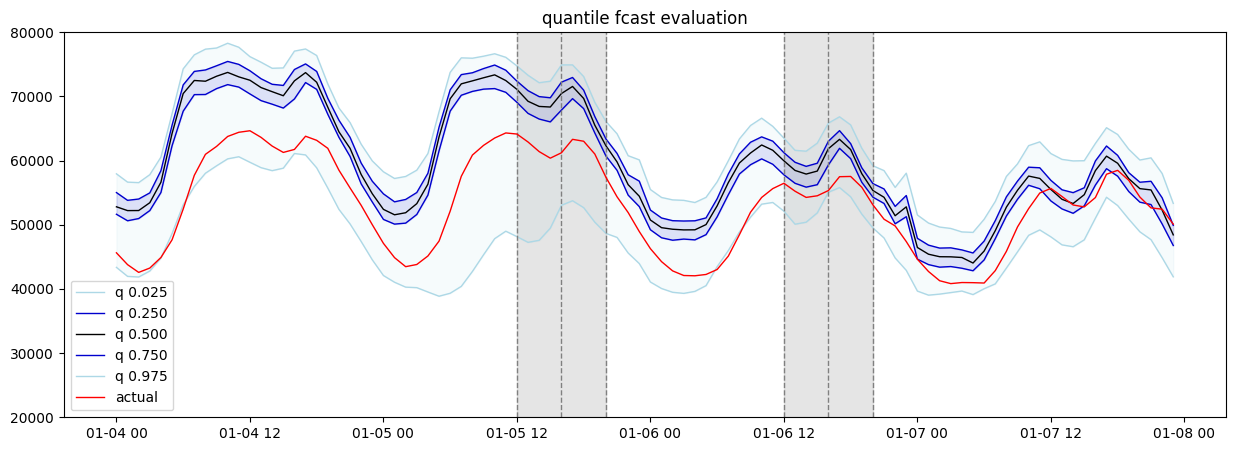

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6688.33984375
MSE = 60096901.95296224
MAPE = 0.12808195265973898
[2577.60048828125, 2607.7132161458335, 3344.169921875, 4065.1637369791665, 5498.529882812498]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 5561.9375


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,6962.1250,0.799294,7.412250,6.962125,4.122500,0.530703
2024-01-05 16:00:00+01:00,9232.1250,0.409230,9.982500,9.232125,5.501344,0.684718
2024-01-05 20:00:00+01:00,4915.6250,0.437302,4.962375,4.915625,2.984938,0.434600
2024-01-06 12:00:00+01:00,3498.7500,0.217620,1.977375,3.498750,2.383625,0.351548
2024-01-06 16:00:00+01:00,6524.7500,0.013101,5.994375,6.524750,3.843000,0.525345
2024-01-06 20:00:00+01:00,2238.2500,0.180152,1.799438,2.238250,1.658000,0.304881
avg,5561.9375,0.342783,5.354719,5.561937,3.415568,0.471966


In [61]:
# iterate over dict dict_benchmark_fcast
for method, df_benchmark in dict_benchmark_fcast.items():
    eval_fcast(df_benchmark, df_energy_new, subm_timestamps, quantiles)